In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Load Dataset
df = pd.read_csv("train.csv")

In [3]:
# Drop rows with missing target
df = df.dropna(subset=['Loan Sanction Amount (USD)'])

# Fill missing values
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('Loan Sanction Amount (USD)')

categorical_cols = df.select_dtypes(include='object').columns.tolist()

for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

# Simultaneously encode categorical variables

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Target-Guided Ordinal Encoding for Categorical Columns
for col in categorical_cols:
    ordering = df.groupby(col)["Loan Sanction Amount (USD)"].mean().sort_values().index
    ordinal_map = {key: idx for idx, key in enumerate(ordering)}
    df[col] = df[col].map(ordinal_map)

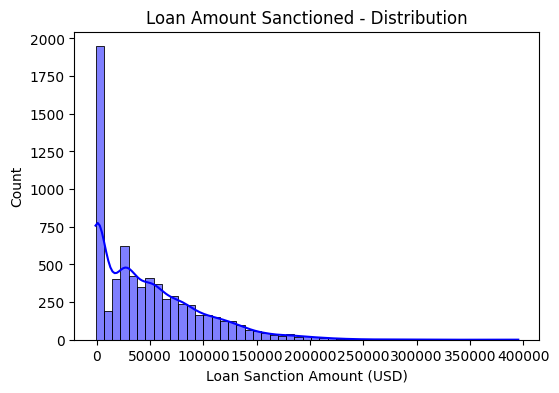

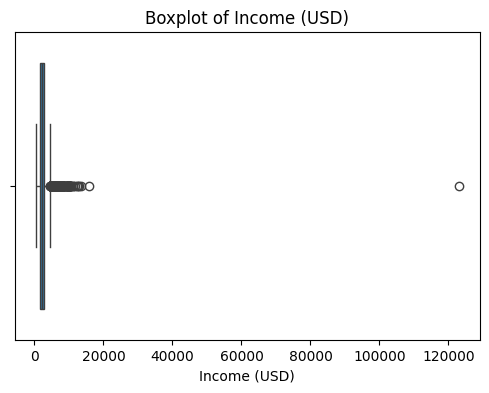

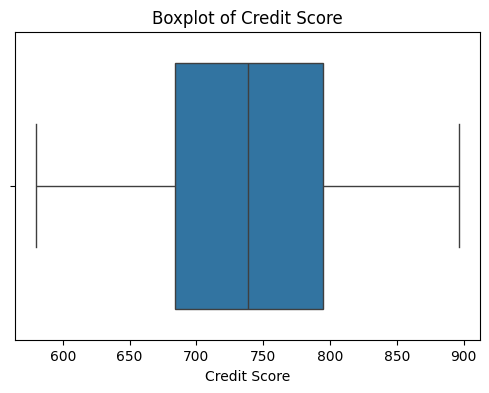

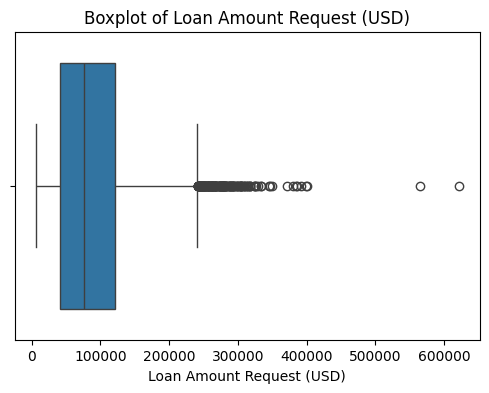

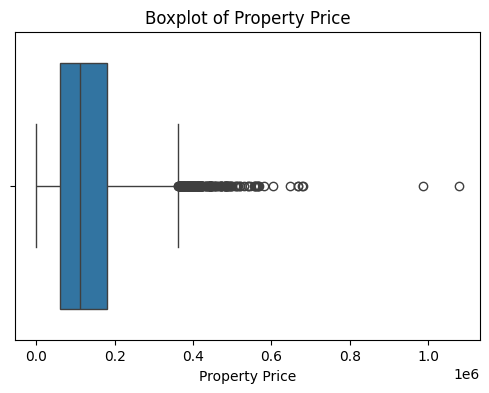

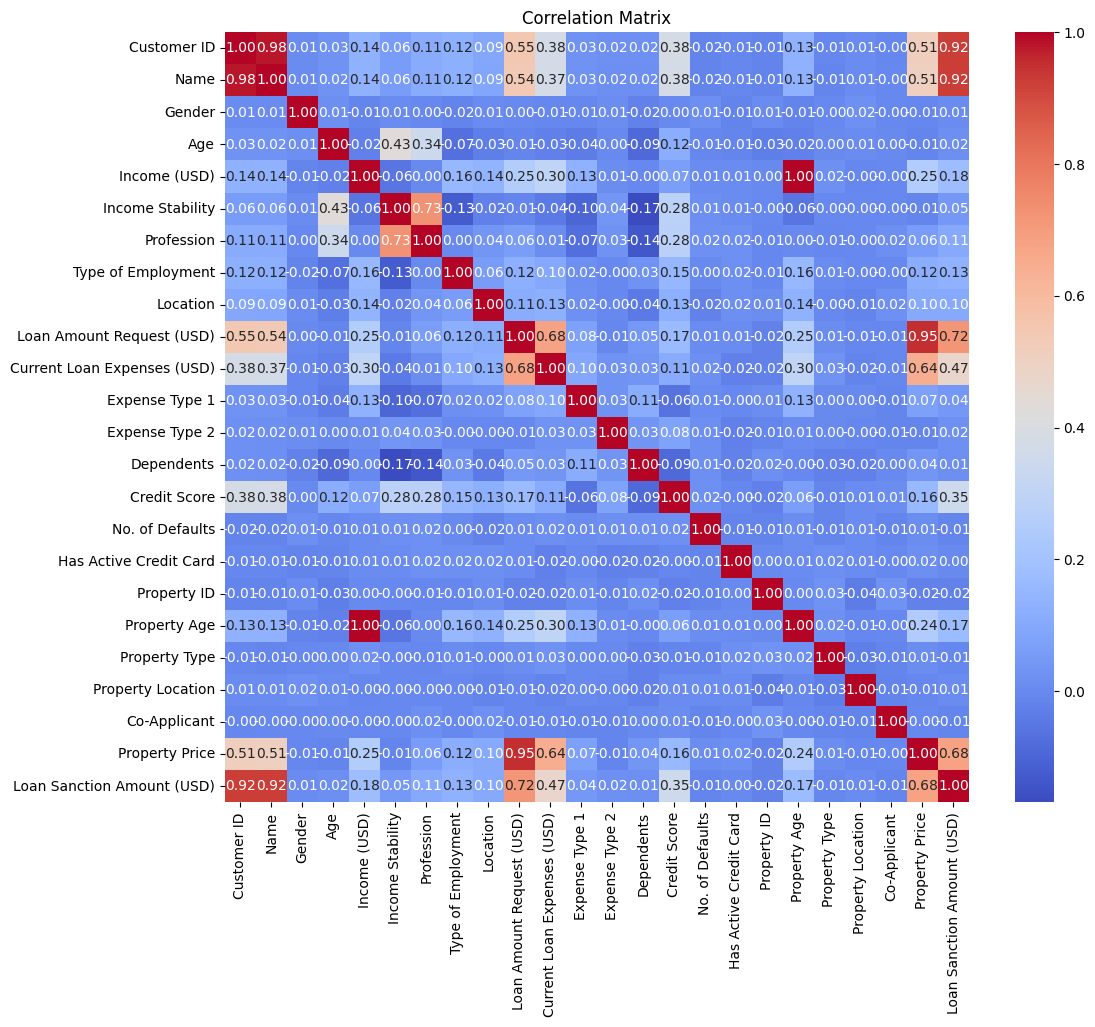

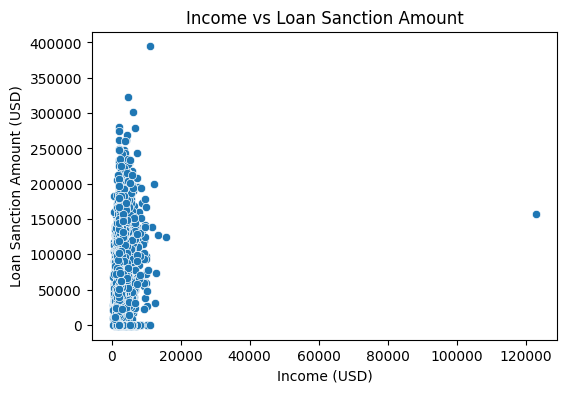

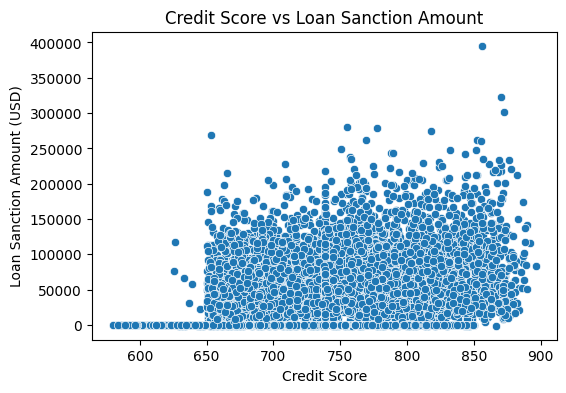

In [4]:
# EDA

# 1. Distribution of Loan Amount
plt.figure(figsize=(6, 4))
sns.histplot(df['Loan Sanction Amount (USD)'], kde=True, color='blue')
plt.title("Loan Amount Sanctioned - Distribution")
plt.show()

# 2. Boxplots for numerical features
for col in ['Income (USD)', 'Credit Score', 'Loan Amount Request (USD)', 'Property Price']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

# 3. Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# 4. Scatter plots
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df['Income (USD)'], y=df['Loan Sanction Amount (USD)'])
plt.title("Income vs Loan Sanction Amount")
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(x=df['Credit Score'], y=df['Loan Sanction Amount (USD)'])
plt.title("Credit Score vs Loan Sanction Amount")
plt.show()

In [5]:
# Feature Engineering
df['DebtToIncomeRatio'] = df['Current Loan Expenses (USD)'] / (df['Income (USD)'] + 1)
df['LoanToPropertyRatio'] = df['Loan Amount Request (USD)'] / (df['Property Price'] + 1)
df['TotalFinancialBurden'] = df['Current Loan Expenses (USD)'] + df['Loan Amount Request (USD)']
df.drop(['Customer ID', 'Name', 'Gender', 'Property ID'], axis=1, inplace=True)

df.to_csv('updated_train.csv', index=False)

# Dataset size (after prepreocessing)
print(df.shape)

(6929, 23)


In [6]:
# Define features and target
X = df.drop('Loan Sanction Amount (USD)', axis=1)
y = df['Loan Sanction Amount (USD)']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Splitting: Train (60%), Validation (20%), Test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [8]:
# ---------------- Linear Kernel ----------------
param_grid_l = {'C': [0.1, 1.0, 10]}
grid_l = GridSearchCV(SVR(kernel='linear'), param_grid_l, cv=5)
grid_l.fit(X_train, y_train)

model_l = grid_l.best_estimator_
y_val_pred_l = model_l.predict(X_val)
y_test_pred_l = model_l.predict(X_test)

# ---------------- Polynomial Kernel ----------------
param_grid_p = {
    'C': [0.1, 1.0, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}
grid_p = GridSearchCV(SVR(kernel='poly'), param_grid_p, cv=5)
grid_p.fit(X_train, y_train)

model_p = grid_p.best_estimator_
y_val_pred_p = model_p.predict(X_val)
y_test_pred_p = model_p.predict(X_test)

# ---------------- RBF Kernel ----------------
param_grid_r = {
    'C': [0.1, 1.0, 10],
    'gamma': ['scale', 'auto']
}
grid_r = GridSearchCV(SVR(kernel='rbf'), param_grid_r, cv=5)
grid_r.fit(X_train, y_train)

model_r = grid_r.best_estimator_
y_val_pred_r = model_r.predict(X_val)
y_test_pred_r = model_r.predict(X_test)

# ---------------- Sigmoid Kernel ----------------
param_grid_s = {
    'C': [0.1, 1.0, 10],
    'gamma': ['scale', 'auto']
}
grid_s = GridSearchCV(SVR(kernel='sigmoid'), param_grid_s, cv=5)
grid_s.fit(X_train, y_train)

model_s = grid_s.best_estimator_
y_val_pred_s = model_s.predict(X_val)
y_test_pred_s = model_s.predict(X_test)

In [9]:
# Evaluating Model using Performance Metrics

def evaluate_model(y_true, y_pred, is_classification, X, model, dataset_name):
    print(f"\n Evaluation - {dataset_name}")
    n, p = X.shape
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print("Mean Squared Error:", mean_squared_error(y_true, y_pred))
    print("Root Mean Squared Error:", root_mean_squared_error(y_true, y_pred))
    print("Mean Absolute Error:", mean_absolute_error(y_true, y_pred))
    print("R2 Score:", r2)
    print("Adjusted R2 Score:", adjusted_r2)

evaluate_model(y_val, y_val_pred_l, True, X_val, model_l, "Validation Set - Linear SVM")
evaluate_model(y_test, y_test_pred_l, True, X_test, model_l, "Test Set - Linear SVM")

evaluate_model(y_val, y_val_pred_p, True, X_val, model_p, "Validation Set - Polynomial SVM")
evaluate_model(y_test, y_test_pred_p, True, X_test, model_p, "Test Set - Polynomial SVM")

evaluate_model(y_val, y_val_pred_r, True, X_val, model_r, "Validation Set - RBF SVM")
evaluate_model(y_test, y_test_pred_r, True, X_test, model_r, "Test Set - RBF SVM")

evaluate_model(y_val, y_val_pred_s, True, X_val, model_s, "Validation Set - Sigmoid SVM")
evaluate_model(y_test, y_test_pred_s, True, X_test, model_s, "Test Set - Sigmoid SVM")


 Evaluation - Validation Set - Linear SVM
Mean Squared Error: 1201017152.1126287
Root Mean Squared Error: 34655.69436777495
Mean Absolute Error: 19743.97531673635
R2 Score: 0.5151275043042227
Adjusted R2 Score: 0.5073012424514662

 Evaluation - Test Set - Linear SVM
Mean Squared Error: 1204795982.1265874
Root Mean Squared Error: 34710.17116245017
Mean Absolute Error: 18811.11986166312
R2 Score: 0.4598233319665932
Adjusted R2 Score: 0.45110441289342007

 Evaluation - Validation Set - Polynomial SVM
Mean Squared Error: 2393818753.334541
Root Mean Squared Error: 48926.667098163765
Mean Absolute Error: 36844.42432679947
R2 Score: 0.033571776114130314
Adjusted R2 Score: 0.01797278790760859

 Evaluation - Test Set - Polynomial SVM
Mean Squared Error: 8208155139.368153
Root Mean Squared Error: 90598.86941550735
Mean Absolute Error: 38143.54289929179
R2 Score: -2.68016988740199
Adjusted R2 Score: -2.7395710154451622

 Evaluation - Validation Set - RBF SVM
Mean Squared Error: 2533117688.782537

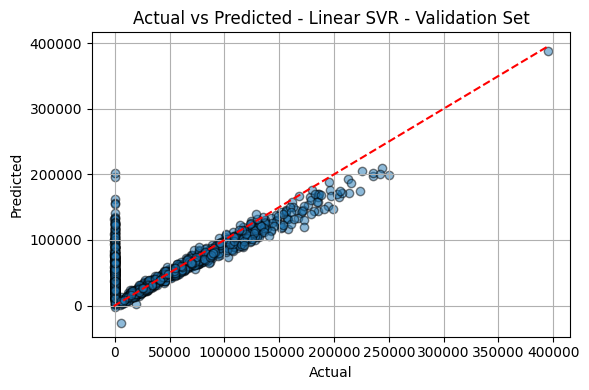

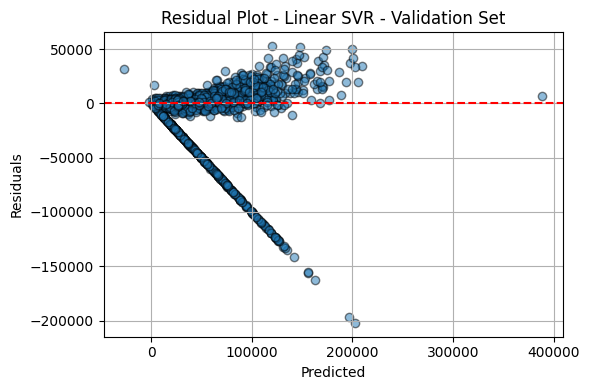

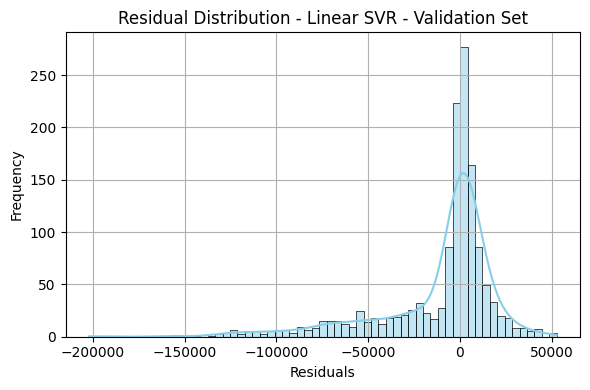

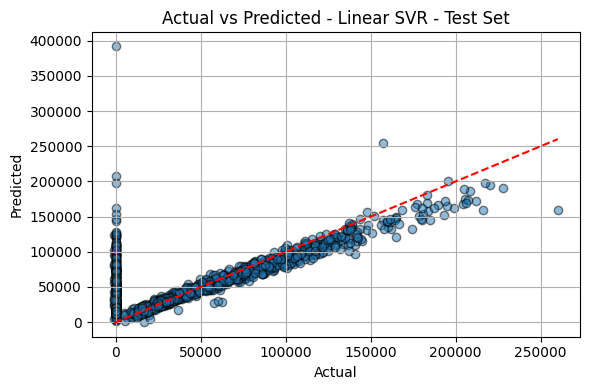

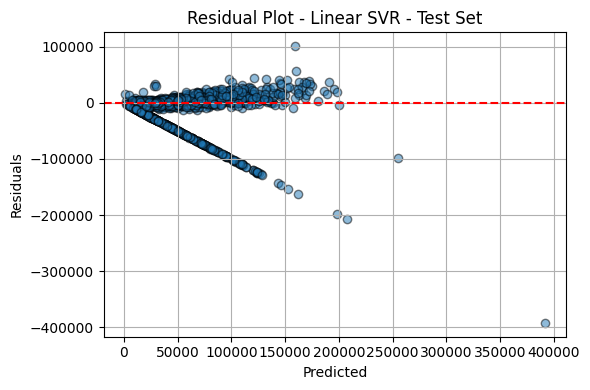

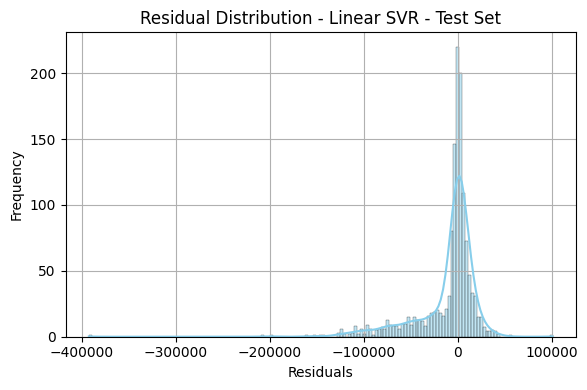

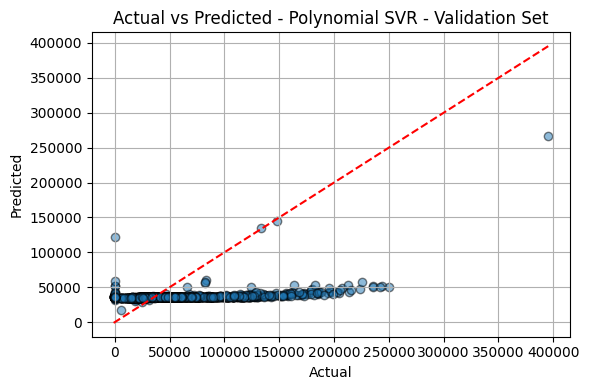

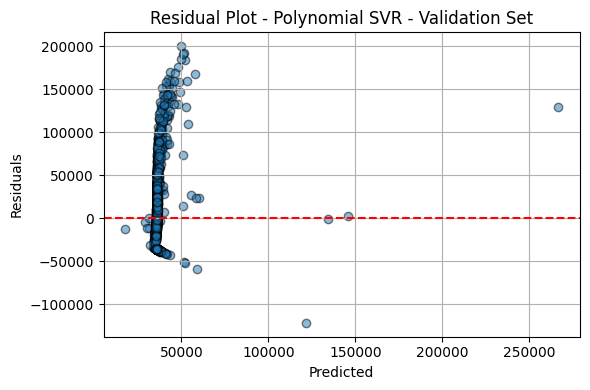

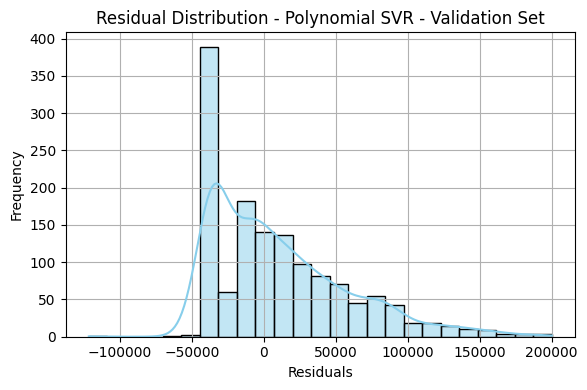

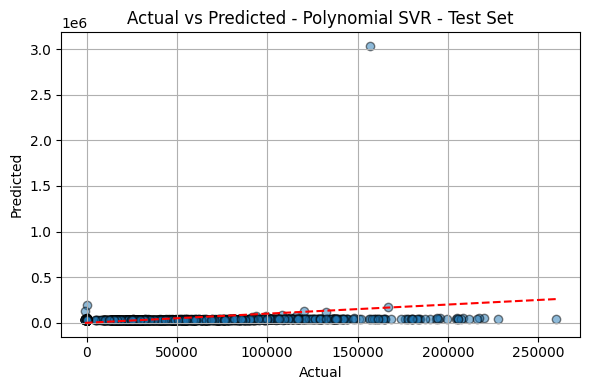

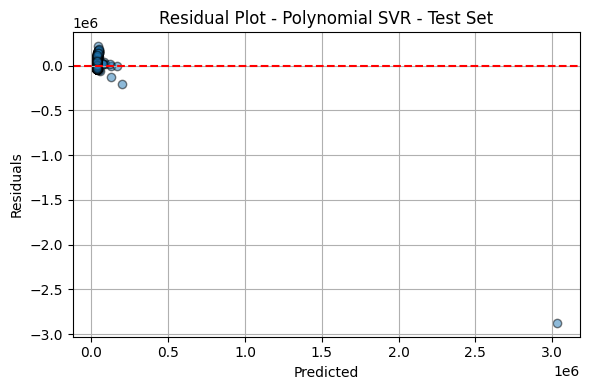

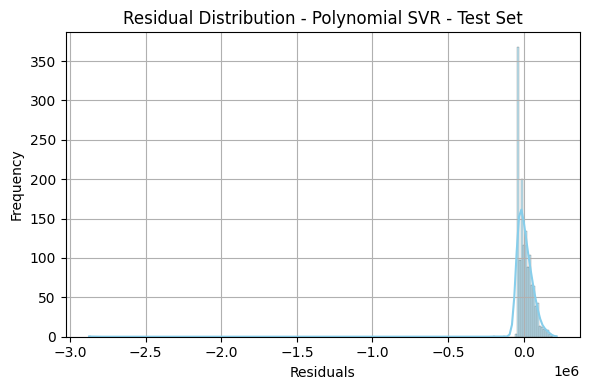

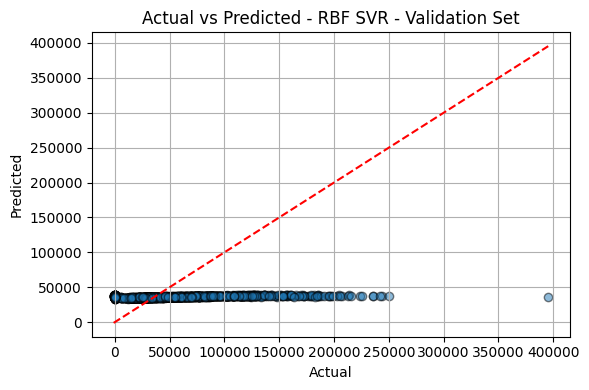

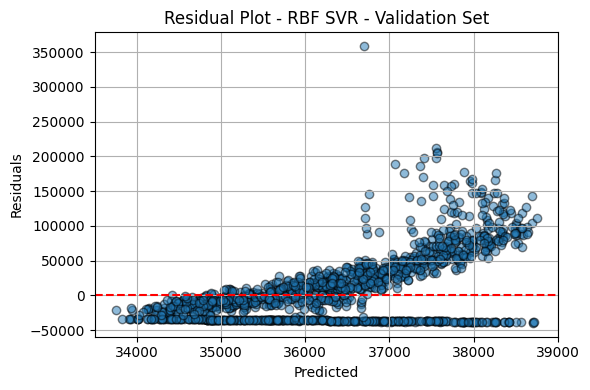

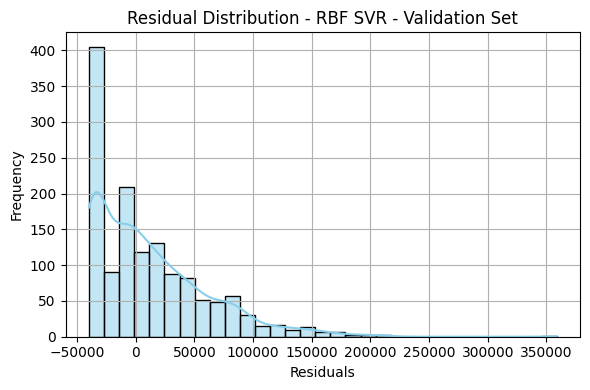

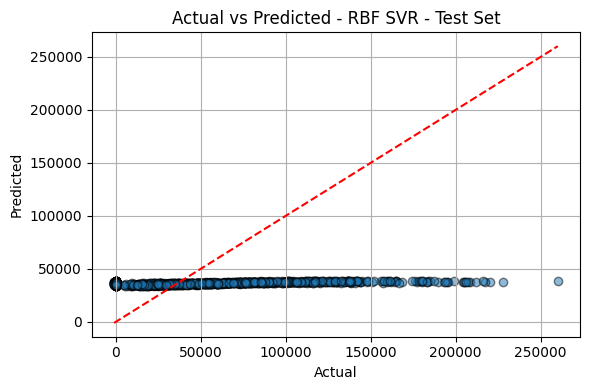

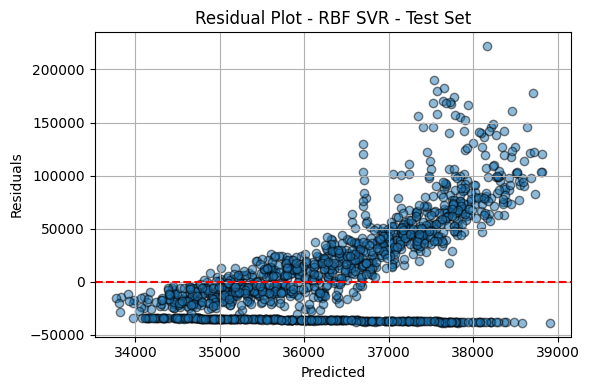

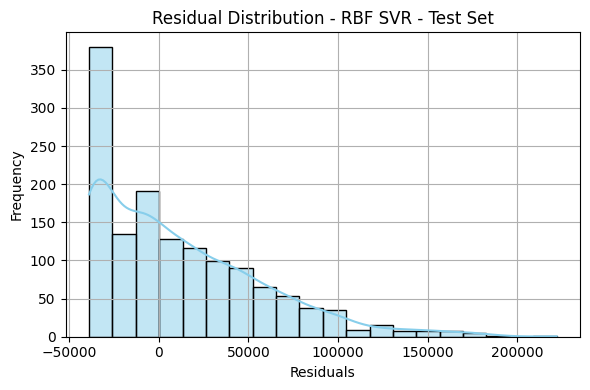

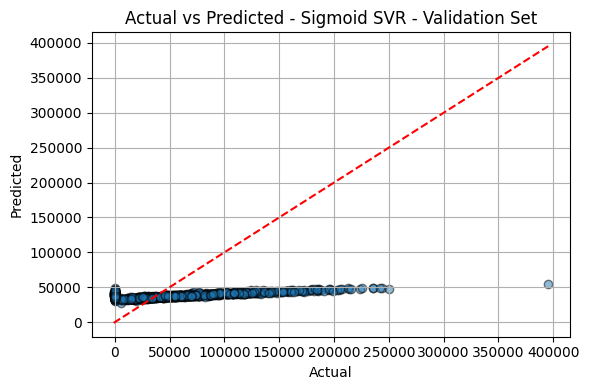

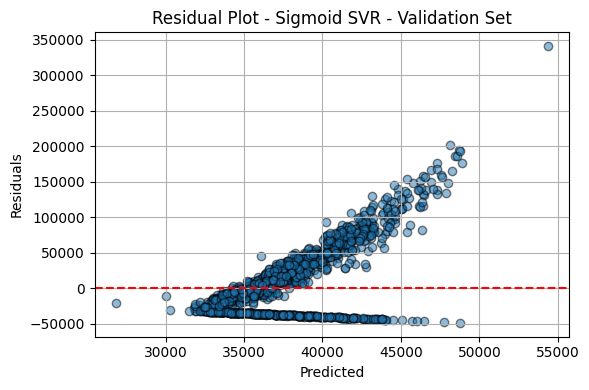

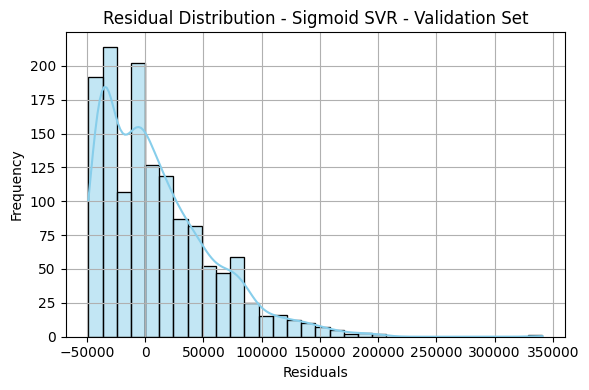

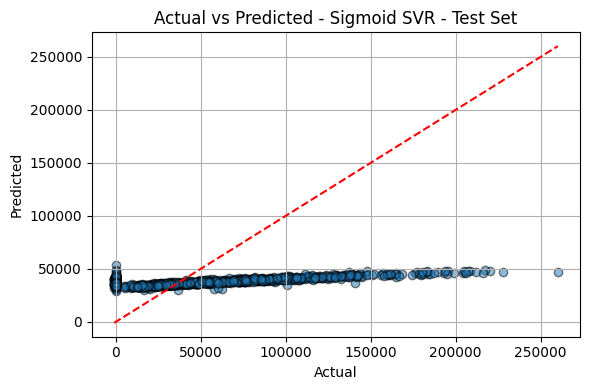

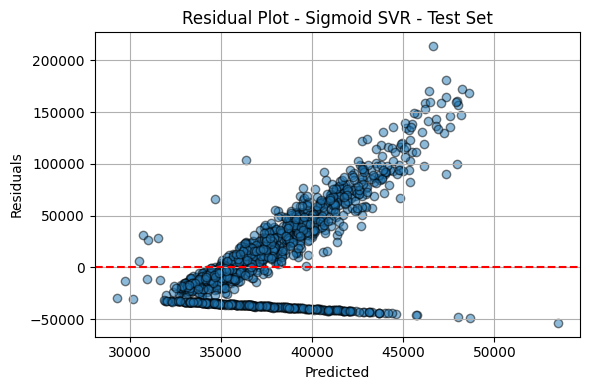

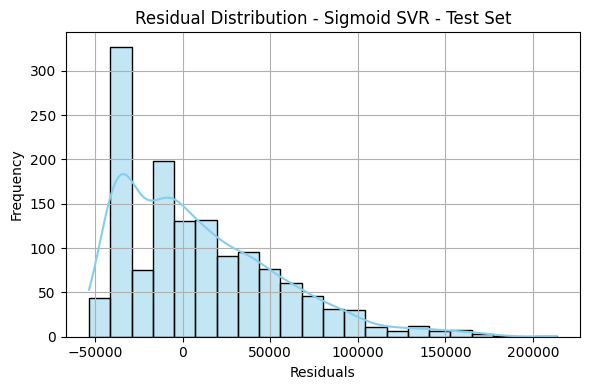

In [10]:
# Evaluating Model on Test and Validation Sets (Without Performance Metrics)

def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolor='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.5, edgecolor='k')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residual_distribution(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, color='skyblue')
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Linear SVR ---
plot_actual_vs_predicted(y_val, y_val_pred_l, "Linear SVR - Validation Set")
plot_residuals(y_val, y_val_pred_l, "Linear SVR - Validation Set")
plot_residual_distribution(y_val, y_val_pred_l, "Linear SVR - Validation Set")

plot_actual_vs_predicted(y_test, y_test_pred_l, "Linear SVR - Test Set")
plot_residuals(y_test, y_test_pred_l, "Linear SVR - Test Set")
plot_residual_distribution(y_test, y_test_pred_l, "Linear SVR - Test Set")

# --- Polynomial SVR ---
plot_actual_vs_predicted(y_val, y_val_pred_p, "Polynomial SVR - Validation Set")
plot_residuals(y_val, y_val_pred_p, "Polynomial SVR - Validation Set")
plot_residual_distribution(y_val, y_val_pred_p, "Polynomial SVR - Validation Set")

plot_actual_vs_predicted(y_test, y_test_pred_p, "Polynomial SVR - Test Set")
plot_residuals(y_test, y_test_pred_p, "Polynomial SVR - Test Set")
plot_residual_distribution(y_test, y_test_pred_p, "Polynomial SVR - Test Set")

# --- RBF SVR ---
plot_actual_vs_predicted(y_val, y_val_pred_r, "RBF SVR - Validation Set")
plot_residuals(y_val, y_val_pred_r, "RBF SVR - Validation Set")
plot_residual_distribution(y_val, y_val_pred_r, "RBF SVR - Validation Set")

plot_actual_vs_predicted(y_test, y_test_pred_r, "RBF SVR - Test Set")
plot_residuals(y_test, y_test_pred_r, "RBF SVR - Test Set")
plot_residual_distribution(y_test, y_test_pred_r, "RBF SVR - Test Set")

# --- Sigmoid SVR ---
plot_actual_vs_predicted(y_val, y_val_pred_s, "Sigmoid SVR - Validation Set")
plot_residuals(y_val, y_val_pred_s, "Sigmoid SVR - Validation Set")
plot_residual_distribution(y_val, y_val_pred_s, "Sigmoid SVR - Validation Set")

plot_actual_vs_predicted(y_test, y_test_pred_s, "Sigmoid SVR - Test Set")
plot_residuals(y_test, y_test_pred_s, "Sigmoid SVR - Test Set")
plot_residual_distribution(y_test, y_test_pred_s, "Sigmoid SVR - Test Set")
